In [68]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

from collections import OrderedDict

In [69]:
# Set seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [70]:
# Function to load GeoJSON data
def load_geojson(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# List of file paths for different species
geojson_paths = [
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Acer_pseudoplatanus_0504.geojson',
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Betula_pendula_0504.geojson',
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Carpinus_betulus_0504.geojson',
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Fagus_sylvatica_0504.geojson',
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Fraxinus_excelsior_0504.geojson',
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Picea_abies_0504.geojson',
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Pinus_sylvestris_0504.geojson',
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Quercus_petraea_0504.geojson',
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Quercus_robur_0504.geojson',
    '/content/drive/MyDrive/Colab Notebooks/DSEO Data/Sorbus_aucuparia_0504.geojson'
]

CLASSES = ['Acer_pseudoplatanus', 'Betula_pendula', 'Carpinus_betulus', 'Fagus_sylvatica', 'Fraxinus_excelsior', 'Picea_abies', 'Pinus_sylvestris', 'Quercus_petraea', 'Quercus_robur', 'Sorbus_aucuparia' ]
# Load data for each species
geojson_data = [(os.path.basename(path).replace('.geojson', ''), load_geojson(path)) for path in geojson_paths]

In [71]:
# Function to normalize using the paper mapping tree species
def normalize_band(band):
    P1 = np.percentile(band, 1)
    P99 = np.percentile(band, 99)
    return (band - P1) / (P99 - P1)


def extract_stack_bands_to_dataframe(geojson_data, bands):
    data = []
    missing_positions = set()

    # First pass to find missing positions
    for geojson_name, geojson in geojson_data:
        for idx, feature in enumerate(geojson['features']):
            for band in bands:
                if band not in feature['properties'] or feature['properties'][band] is None:
                    missing_positions.add((geojson_name, idx))

    # Second pass to collect data excluding missing positions
    for geojson_name, geojson in geojson_data:
        for idx, feature in enumerate(geojson['features']):
            if (geojson_name, idx) in missing_positions:
                continue
            properties = feature['properties']
            X = []
            for band in bands:
                band_data = properties.get(band, None)
                if band_data is not None:
                    band_array = np.array(band_data)
                    normalized_band = normalize_band(band_array)
                X.append(normalized_band)
            if X:
                combined_image = np.stack(X, axis=-1)  # Shape will be (5, 5, 10)
                entry = {
                    "name": geojson_name,
                    "index": idx + 1,
                    "image": combined_image,
                    "label": geojson_name  # assuming label is the name of the species
                }
                data.append(entry)
    print(len(data))
    return data

# All bands to extract,change
all_bands_spring = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'B2_1', 'B3_1', 'B4_1', 'B5_1', 'B6_1', 'B7_1', 'B8_1', 'B8A_1', 'B11_1', 'B12_1']
# Extract and save images into DataFrame
data = extract_stack_bands_to_dataframe(geojson_data, all_bands_spring)

14482


In [72]:
df = pd.DataFrame(data)

In [73]:
# Extract the 'name' column to a list
name_list = df['name'].to_list()

# Count occurrences of each unique name
name_counts = {name: name_list.count(name) for name in name_list}

# Extract the unique names from geojson_paths in the order they appear
ordered_names = [os.path.basename(path).replace('_0504.geojson', '_0504') for path in geojson_paths]

# Sort the name_counts according to the sequence of names in ordered_names
sorted_name_counts = OrderedDict()
for name in ordered_names:
    if name in name_counts:
        sorted_name_counts[name] = name_counts[name]

print("Sorted Name Counts:", sorted_name_counts)

# Convert counts to a numpy array
counts = np.array(list(sorted_name_counts.values()))

# Calculate weights as the inverse of counts
class_weights = 1. / counts

# Optionally scale weights if they are too small
scaling_factor = 100  # Adjust this factor as needed
class_weights *= scaling_factor

# Normalize weights (optional but usually a good practice)
# class_weights = class_weights / class_weights.sum()

# Convert to a tensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Print the class weights
print("Class Weights: ", class_weights_tensor)

Sorted Name Counts: OrderedDict([('Acer_pseudoplatanus_0504', 747), ('Betula_pendula_0504', 561), ('Carpinus_betulus_0504', 882), ('Fagus_sylvatica_0504', 2279), ('Fraxinus_excelsior_0504', 851), ('Picea_abies_0504', 3754), ('Pinus_sylvestris_0504', 3163), ('Quercus_petraea_0504', 1170), ('Quercus_robur_0504', 831), ('Sorbus_aucuparia_0504', 244)])
Class Weights:  tensor([0.1339, 0.1783, 0.1134, 0.0439, 0.1175, 0.0266, 0.0316, 0.0855, 0.1203,
        0.4098], device='cuda:0')


In [74]:
# Prepare the data for training
X = [item['image'] for item in data]
y = [item['label'] for item in data]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = torch.tensor(y_encoded, dtype=torch.long)

# First split: train and temp (with temp later split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_one_hot, test_size=0.4, random_state=42)
# Second split: validation and test (split temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [75]:
# Custom Dataset class
class TreeDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to tensor and change to (C, H, W)
        if self.transform:
            image = self.transform(image)
        return image, label

In [76]:
# Transformations for the dataset
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(size=(64, 64)),  # Resize
])

# Create Dataset instances
train_ds = TreeDataset(X_train, y_train, data_transform)
valid_ds = TreeDataset(X_val, y_val, data_transform)
test_ds = TreeDataset(X_test, y_test, data_transform)

# Define a seed worker function for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)


# Create DataLoaders
batch_size = 32 # One hyperparameter
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, pin_memory=True)

In [77]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))


class MulticlassClassifierBase(nn.Module):

    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}

    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [78]:
class ResNet18(MulticlassClassifierBase):
    def __init__(self):
        super(ResNet18, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)

        # Modify the first convolutional layer to accept 20 input channels
        self.resnet.conv1 = nn.Conv2d(20, 64, kernel_size=20, stride=2, padding=3, bias=False)


        # Get the number of input features to the fully connected layer
        num_ftrs = self.resnet.fc.in_features

        # Modify the final fully connected layer to output 10 classes
        self.resnet.fc = nn.Linear(num_ftrs, 10)

    def forward(self, xb):
        return self.resnet(xb)

    def freeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def unfreeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = True

In [79]:
model = ResNet18()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [80]:
# Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)


torch.Size([32, 20, 64, 64])
torch.Size([32, 10])
tensor([-0.8136, -0.3101, -0.1297,  0.8484,  0.2600, -0.0277, -0.7495,  0.7065,
        -0.1425, -0.6841], grad_fn=<SelectBackward0>)


In [81]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield self.to_device(b)

    def __len__(self):
        return len(self.dl)

    def to_device(self, b):
        if isinstance(b, (list, tuple)):
            return [self.to_device(x) for x in b]
        return b.to(self.device, non_blocking=True)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [82]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return torch.device('cuda')
    else:
        print("CUDA is not available. Using CPU.")
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [83]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(model, device)
## lets try passing a batch to model again
try_batch(train_dl)

cuda
torch.Size([32, 20, 64, 64])
torch.Size([32, 10])
tensor([-0.1919, -0.2584,  2.1542,  0.5211,  0.6418, -0.3589, -1.7666,  0.8467,
        -0.7841, -1.8388], device='cuda:0', grad_fn=<SelectBackward0>)


In [84]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):

    history = []
    valid_loss_min = np.inf
    valid_acc_max = 0
    model_file_name = './googlenet.pth'
    model_file_name2 = './googlenet_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)

    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):

            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))

        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history

        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

In [85]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 20
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, valid_dl)

{'val_loss': 2.4350452423095703, 'val_acc': 0.13358516991138458}

In [86]:
## Freezing except last layer
## model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.2634, learning_rate: 0.0010, train_loss: 2.0564, val_loss: 2.2021, val_acc: 0.2957


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.3054, learning_rate: 0.0010, train_loss: 1.9321, val_loss: 1.9365, val_acc: 0.3139


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.3091, learning_rate: 0.0010, train_loss: 1.8957, val_loss: 2.5337, val_acc: 0.3194


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.3065, learning_rate: 0.0010, train_loss: 1.8684, val_loss: 7.6576, val_acc: 0.2785


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.3052, learning_rate: 0.0010, train_loss: 1.8680, val_loss: 1.9043, val_acc: 0.3225


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.3044, learning_rate: 0.0010, train_loss: 1.8599, val_loss: 1.8513, val_acc: 0.3400


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.3175, learning_rate: 0.0010, train_loss: 1.8324, val_loss: 2.1040, val_acc: 0.2854


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.3100, learning_rate: 0.0010, train_loss: 1.8234, val_loss: 1.8071, val_acc: 0.3434


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.3162, learning_rate: 0.0010, train_loss: 1.8330, val_loss: 1.7749, val_acc: 0.3001


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.3268, learning_rate: 0.0010, train_loss: 1.8033, val_loss: 1.8908, val_acc: 0.3163


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.3257, learning_rate: 0.0010, train_loss: 1.7917, val_loss: 1.7851, val_acc: 0.3383


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.3248, learning_rate: 0.0010, train_loss: 1.7748, val_loss: 1.7983, val_acc: 0.3389


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.3361, learning_rate: 0.0000, train_loss: 1.7630, val_loss: 1.7301, val_acc: 0.3496


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.3378, learning_rate: 0.0000, train_loss: 1.7586, val_loss: 1.7363, val_acc: 0.3462


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.3359, learning_rate: 0.0000, train_loss: 1.7555, val_loss: 1.7359, val_acc: 0.3530


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.3367, learning_rate: 0.0000, train_loss: 1.7594, val_loss: 1.7380, val_acc: 0.3472


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.3341, learning_rate: 0.0000, train_loss: 1.7667, val_loss: 1.7360, val_acc: 0.3513


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.3346, learning_rate: 0.0000, train_loss: 1.7597, val_loss: 1.7346, val_acc: 0.3482


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.3382, learning_rate: 0.0000, train_loss: 1.7605, val_loss: 1.7379, val_acc: 0.3492


  0%|          | 0/272 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.3372, learning_rate: 0.0000, train_loss: 1.7620, val_loss: 1.7351, val_acc: 0.3513
VAL LOSS MIN 1.730107307434082
VAL ACC MAX 0.3530219793319702


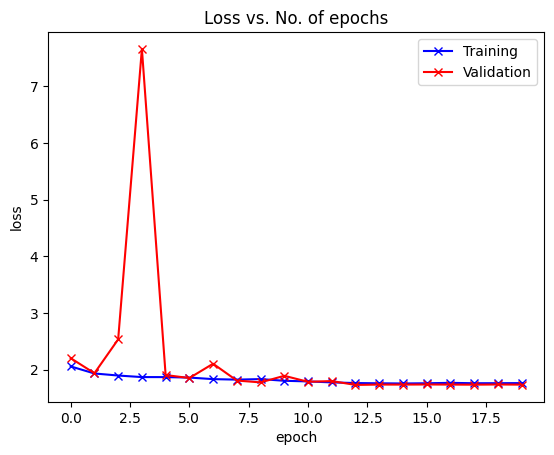

In [87]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

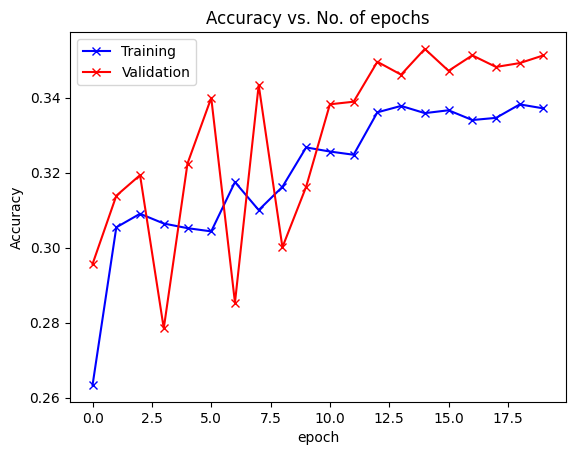

In [88]:
def plot_accuracy(history):

    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

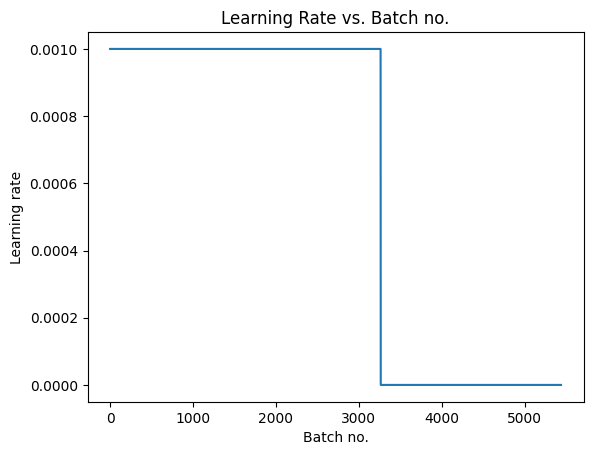

In [89]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

In [90]:
batch_size = 1
@torch.no_grad()
def predict_dl(dl, model, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the model to the appropriate device
    torch.cuda.empty_cache()
    batch_pred, all_labels = [], []

    for xb, label in tqdm(dl):
        xb, label = to_device(xb, device), to_device(label, device)  # Move data to the same device as the model
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())
        all_labels.append(label.cpu().detach())  # Ensure labels are moved to CPU and detached

    # Flatten the list of tensors
    batch_pred = torch.cat(batch_pred).numpy()
    all_labels = torch.cat(all_labels).numpy()

    return batch_pred, all_labels


In [91]:
def final_accuracy(predictions, labels):
    ## Total Accuracy
    total = 0
    for i in range(len(predictions)):
        if predictions[i] == labels[i]:
            total += 1
    acc = total / len(predictions)
    print(f"Total Accuracy: {acc:.4f}")


In [ ]:

full_ds = TreeDataset(X, y_one_hot, data_transform)
full_dl = DataLoader(full_ds, batch_size, shuffle=True, pin_memory=True)
full_dl = DeviceDataLoader(full_dl, device)

# Predict and evaluate
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)

# Convert predictions and labels to numpy arrays for confusion matrix
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]

# Compute confusion matrix
cm = confusion_matrix(labs, preds, labels=np.arange(len(CLASSES)))

# Calculate accuracy for each ground truth label
accuracies = {}
for i in range(len(CLASSES)):
    true_positive = cm[i, i]
    total_samples = np.sum(cm[i, :])
    if total_samples > 0:
        accuracies[CLASSES[i]] = true_positive / total_samples
    else:
        accuracies[CLASSES[i]] = None

print("Confusion Matrix:\n", cm)
print("Accuracies:\n", accuracies)

cm

  0%|          | 0/14482 [00:00<?, ?it/s]

In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)

In [ ]:
model.load_state_dict(torch.load('./googlenet.pth'))
model.eval()
model = to_device(model, device)
# Predict and evaluate
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)

# Convert predictions and labels to numpy arrays for confusion matrix
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]

# Compute confusion matrix
cm = confusion_matrix(labs, preds, labels=np.arange(len(CLASSES)))

# Calculate accuracy for each ground truth label
accuracies = {}
for i in range(len(CLASSES)):
    true_positive = cm[i, i]
    total_samples = np.sum(cm[i, :])
    if total_samples > 0:
        accuracies[CLASSES[i]] = true_positive / total_samples
    else:
        accuracies[CLASSES[i]] = None

print("Confusion Matrix:\n", cm)
print("Accuracies:\n", accuracies)

cm

In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)